In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import time
import numpy as np
import geopandas as gpd
import xarray as xr
import os
from itertools import product
from scipy.stats import pearsonr
import numpy as np
from numba import njit
import random
from joblib import Parallel, delayed

In [2]:
@njit
def time_evolution_numba_without_theta(temp, rad, prec, ndvi, c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w):
    #Initialize 
    length = len(temp)
    runoff_out = np.full(length, np.nan)
    evapo_out = np.full(length, np.nan)
    soil_mois_out = np.full(length, np.nan)
    snow_out = np.full(length, np.nan)

    # Transformations / Calculations for Setup
    conv = 1 / 2260000  # from J/day/m**2 to mm/day
    rad = rad * conv  # convert radiation to mm/day
    prec = prec * 10 **3 # from m/day to mm/day
    w = 0.9 * c_s
    snow = 0

    # --- calc_et_weight function ---
    ndvi = np.nan_to_num(ndvi, nan=0.0)
    normalized_temp = (temp - temp.min()) / (temp.max() - temp.min())
    normalized_ndvi = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())
    et_weight = temp_w * normalized_temp + ndvi_w * normalized_ndvi
    beta_weighted = beta * et_weight

    for t in range(1, length):
        prec_t = prec[t-1]
        temp_t = temp[t-1]
        rad_t = rad[t-1]
        beta_t = beta_weighted[t-1]

        # ---- snow_function ----
        is_melting = temp_t > 273.15
        has_snow = snow >= 0.001

        if not is_melting:
            snow = snow + prec_t
            water = 0.0
        elif is_melting and has_snow:
            melt = c_m * (temp_t - 273.15)
            melt = min(melt, snow)
            snow = snow - melt
            water = melt + prec_t
        else:
            water = prec_t

        runoff = (water + iota) * (w / c_s) ** alpha
        evap = beta_t * (w / c_s) ** gamma * rad_t

        w = w + (water - runoff - evap)
        w = np.maximum(w, 0.0)

        # Store results
        runoff_out[t] = runoff
        evapo_out[t] = evap
        soil_mois_out[t] = w
        snow_out[t] = snow

    return runoff_out, evapo_out, soil_mois_out, snow_out

In [2]:
@njit
def time_evolution_numba(temp, rad, prec, ndvi, c_s, alpha, beta, gamma, c_m, iota, theta, temp_w, ndvi_w):
    #Initialize 
    length = len(temp)
    runoff_out = np.full(length, np.nan)
    evapo_out = np.full(length, np.nan)
    soil_mois_out = np.full(length, np.nan)
    snow_out = np.full(length, np.nan)

    # Transformations / Calculations for Setup
    conv = 1 / 2260000  # from J/day/m**2 to mm/day
    rad = rad * conv  # convert radiation to mm/day
    prec = prec * 10 **3 # from m/day to mm/day
    w = 0.9 * c_s
    snow = 0

    # --- calc_et_weight function ---
    ndvi = np.nan_to_num(ndvi, nan=0.0)
    normalized_temp = (temp - temp.min()) / (temp.max() - temp.min())
    normalized_ndvi = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())
    et_weight = temp_w * normalized_temp + ndvi_w * normalized_ndvi
    beta_weighted = beta * et_weight

    for t in range(1, length):
        prec_t = prec[t-1]
        temp_t = temp[t-1]
        rad_t = rad[t-1]
        beta_t = beta_weighted[t-1]

        # ---- snow_function ----
        is_melting = temp_t > 273.15
        has_snow = snow >= 0.001

        if not is_melting:
            snow = snow + prec_t
            water = 0.0
        elif is_melting and has_snow:
            melt = c_m * (temp_t - 273.15)
            melt = min(melt, snow)
            snow = snow - melt
            water = melt + prec_t
        else:
            water = prec_t

        baseflow = iota * (w / c_s) ** theta
        runoff = water * (w / c_s) ** alpha + baseflow
        evap = beta_t * (w / c_s) ** gamma * rad_t

        w = w + (water - runoff - evap)
        w = np.maximum(w, 0.0)

        # Store results
        runoff_out[t] = runoff
        evapo_out[t] = evap
        soil_mois_out[t] = w
        snow_out[t] = snow

    return runoff_out, evapo_out, soil_mois_out, snow_out

In [8]:
@njit
def time_evolution_numba_old(temp, rad, prec, ndvi, c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w):
    #Initialize 
    length = len(temp)
    runoff_out = np.full(length, np.nan)
    evapo_out = np.full(length, np.nan)
    soil_mois_out = np.full(length, np.nan)
    snow_out = np.full(length, np.nan)

    # Transformations / Calculations for Setup
    conv = 1 / 2260000  # from J/day/m**2 to mm/day
    rad = rad * conv  # convert radiation to mm/day
    prec = prec * 10 **3 # from m/day to mm/day
    w = 0.9 * c_s
    snow = 0

    # --- calc_et_weight function ---
    ndvi = np.nan_to_num(ndvi, nan=0.0)
    normalized_temp = (temp - temp.min()) / (temp.max() - temp.min())
    normalized_ndvi = (ndvi - ndvi.min()) / (ndvi.max() - ndvi.min())
    et_weight = temp_w * normalized_temp + ndvi_w * normalized_ndvi
    beta_weighted = beta * et_weight

    for t in range(1, length):
        prec_t = prec[t-1]
        temp_t = temp[t-1]
        rad_t = rad[t-1]
        beta_t = beta_weighted[t-1]

        # ---- snow_function ----
        is_melting = temp_t > 273.15
        has_snow = snow >= 0.001

        if not is_melting:
            snow = snow + prec_t
            water = 0.0
        elif is_melting and has_snow:
            melt = c_m * (temp_t - 273.15)
            melt = min(melt, snow)
            snow = snow - melt
            water = melt + prec_t
        else:
            water = prec_t

        runoff = (water + iota) * (w / c_s) ** alpha
        evap = beta_t * (w / c_s) ** gamma * rad_t

        w = w + (water - runoff - evap)
        w = np.maximum(w, 0.0)

        # Store results
        runoff_out[t] = runoff
        evapo_out[t] = evap
        soil_mois_out[t] = w
        snow_out[t] = snow

    return runoff_out, evapo_out, soil_mois_out, snow_out

In [3]:
class WaterModel:
    def __init__(self, params: dict, data):
        self.params = params
        self.data = data

    def run_simulation_whole_catchment(self):
        runoff,_,_,_= time_evolution_numba_without_theta(
            self.data['temperature'].values,
            self.data['radiation'].values,
            self.data['precipitation'].values,
            self.data['ndvi'].values,
            self.params['c_s'],
            self.params['alpha'],
            self.params['beta'],
            self.params['gamma'],
            self.params['c_m'],
            self.params['iota'],
            #self.params['theta'],
            self.params['temp_w'],
            self.params['ndvi_w']
        )
        return runoff

In [4]:
data_path = r"data/catchments/GRDC-Daily.nc"

runoff = xr.open_mfdataset(data_path).load()
runoff = runoff.sel(time=slice('2000-03-01', '2022-12-19'))

bentfeld_id = runoff["station_name"].values == "BENTFELD"
bentfeld_index = np.where(bentfeld_id)[0][0]

# Select only that timeseries
runoffBentfeld = runoff["runoff_mean"].isel(id=bentfeld_index)

bentfeld_path = r"data/catchment_timeseries/bentfeld"

temperature = xr.open_mfdataset(bentfeld_path + '/temperature.nc', combine='by_coords').load()
precipitation = xr.open_mfdataset(bentfeld_path + '/precipitation.nc', combine='by_coords').load()
radiation = xr.open_mfdataset(bentfeld_path + '/radiation.nc', combine='by_coords').load()
ndvi = xr.open_mfdataset(bentfeld_path + '/ndvi.nc', combine='by_coords').load()

data = xr.Dataset()
data['temperature'] = temperature['t2m']
data['precipitation'] = precipitation['precipitation']
data['radiation'] = radiation['nr']
data['ndvi'] = ndvi['ndvi']
data['observedRunoff'] = runoffBentfeld.broadcast_like(radiation['nr'])

#get rid of anythin before 2000 and after 2022
data = data.sel(time=slice('2000-03-01', '2022-12-19'))
data

<xarray.Dataset> Size: 7MB
Dimensions:         (time: 8329, x: 5, y: 5)
Coordinates:
  * time            (time) datetime64[ns] 67kB 2000-03-01 ... 2022-12-19
  * x               (x) float64 40B 8.55 8.65 8.75 8.85 8.95
  * y               (y) float64 40B 51.85 51.75 51.65 51.55 51.45
    spatial_ref     int64 8B 0
    id              int32 4B 6335082
Data variables:
    temperature     (time, y, x) float32 833kB nan nan nan ... 276.1 nan nan
    precipitation   (time, y, x) float64 2MB nan nan nan ... 0.004961 nan nan
    radiation       (time, y, x) float64 2MB nan nan nan ... -2.438e+04 nan nan
    ndvi            (time, y, x) float64 2MB nan nan nan ... 0.6008 nan nan
    observedRunoff  (time, y, x) float32 833kB 33.08 33.08 33.08 ... nan nan nan

In [ ]:
def create_evaluator(temp, rad, prec, ndvi, observed, time_evolution_func):
    """Factory function with consistent types."""
    # Convert inputs to float32 and ensure contiguous
    temp = np.ascontiguousarray(temp, dtype=np.float32)
    rad = np.ascontiguousarray(rad, dtype=np.float32)
    prec = np.ascontiguousarray(prec, dtype=np.float32)
    ndvi = np.ascontiguousarray(ndvi, dtype=np.float32)
    observed = np.ascontiguousarray(observed, dtype=np.float32)

    @njit(fastmath=True)
    def evaluate_fast(params):
        """Type-consistent evaluation."""
        c_s, alpha, beta, gamma, c_m, iota, temp_w, ndvi_w = (
            np.float32(p) for p in params
        )
        
        simulated = time_evolution_func(
            temp=temp,
            rad=rad,
            prec=prec,
            ndvi=ndvi,
            c_s=c_s,
            alpha=alpha,
            beta=beta,
            gamma=gamma,
            c_m=c_m,
            iota=iota,
            temp_w=temp_w,
            ndvi_w=ndvi_w
        )[0]
        
        return compute_correlation_numba(observed, simulated)
    
    return evaluate_fast

In [11]:
dataMean = xr.Dataset()
dataMean['temperature'] = data["temperature"].mean(dim=("x", "y"))
dataMean['precipitation'] = data["precipitation"].mean(dim=("x", "y"))
dataMean['radiation'] = data["radiation"].mean(dim=("x", "y"))
dataMean['ndvi'] = data["ndvi"].mean(dim=("x", "y"))
dataMean['observedRunoff'] = data["observedRunoff"].sum(dim=("x", "y"))  
params_new = {
    "c_s": 840,
    "alpha": 8,
    "gamma": 0.5,
    "beta": 0.8,
    "c_m": 2.0,
    "temp_w": 0.75,
    "ndvi_w": 0.5,
    "iota": 10,
    "theta": 5
}

wm_new = WaterModel(params=params_new, data= dataMean)
runoff_new = wm_new.run_simulation_whole_catchment()

In [12]:
start_time = time.time()
wm_new = WaterModel(params=params_new, data= dataMean)
runoff_new = wm_new.run_simulation_whole_catchment()
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

calculations completed in 0.00000 seconds.


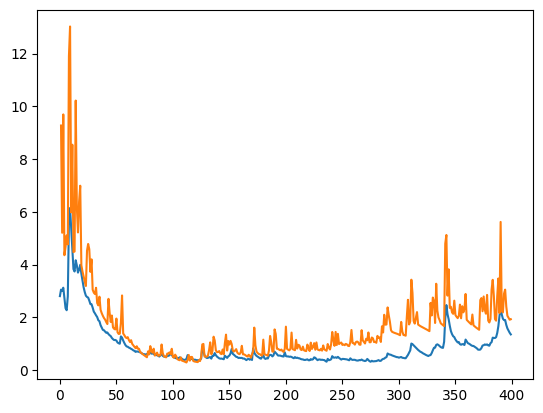

In [12]:
normalized = (data["observedRunoff"]*86400/(1018*1000))
plt.plot(normalized[:400].mean(dim=("x", "y")))
plt.plot(runoff_new[:400])
plt.show()

In [13]:
x = runoff_new
y = normalized.mean(dim=("x", "y")).values.flatten()

# Create a mask for non-NaN values in both arrays
mask = ~np.isnan(x) & ~np.isnan(y)

# Apply the mask and then compute Pearson correlation
r2_new = pearsonr(x[mask], y[mask])[0]
r2_new

np.float64(0.8697734804694942)

In [5]:
class Calibrator:
    def __init__(self, initParams, rasterData, areaSize, numCombi = 3, numIter = 3):
        self.params = initParams
        self.areaSize = areaSize
        self.rasterData = self.calculate_catchment_mean(rasterData)
        self.numCombi = numCombi
        self.numIter = numIter        

    def calculate_catchment_mean(self, data):
        dataMean = xr.Dataset()
        dataMean['temperature'] = data["temperature"].mean(dim=("x", "y"))
        dataMean['precipitation'] = data["precipitation"].mean(dim=("x", "y"))
        dataMean['radiation'] = data["radiation"].mean(dim=("x", "y"))
        dataMean['ndvi'] = data["ndvi"].mean(dim=("x", "y"))
        dataMean['observedRunoff'] = self.normalize_observedRunoff(data["observedRunoff"].sum(dim=("x", "y")), self.areaSize)
        return dataMean
    
    def normalize_observedRunoff(self, observedRunoff, areaSize):
        return observedRunoff*86400/(areaSize*1000)

    def create_paramsChoice(self, params, i):
        paramsChoice = {key: [
            value-value/(2**i),
            value, 
            value+value/(2**i)]
                for key, value in params.items()}
        return paramsChoice

    def split_data(self, data, splitPerc):
        leng = data.sizes["time"]
        maxYear = leng/365
        sample = np.random.randint(0, maxYear, int(maxYear*splitPerc))
        mask = np.zeros(leng, dtype=bool)
        for s in sample:
            mask[s*365:(s+1)*365] = True
        train = data.isel(time=np.where(~mask)[0])
        test = data.isel(time=np.where(mask)[0])

        return train, test

    def calibrate_pixel(self, paramsChoice, valTrain):
        allCombinations = list(product(*paramsChoice.values()))
        randomCombinationsSample = random.sample(allCombinations, self.numCombi)
        param_dicts = [
            dict(zip(paramsChoice.keys(), combo)) for combo in randomCombinationsSample
        ]
        train, val = self.split_data(valTrain, 0.9)

        observed = train["observedRunoff"].values
        nan_mask_obs = ~np.isnan(observed)        

        def evaluate(params):
            wm = WaterModel(params=params, data=train)
            runoff = wm.run_simulation_whole_catchment()
            mask = nan_mask_obs & ~np.isnan(runoff)

            if np.sum(mask) < 2:
                return params, -np.inf

            r, _ = pearsonr(runoff[mask], observed[mask])
            return params, r
        
        results = Parallel(n_jobs=-1)(delayed(evaluate)(params) for params in param_dicts)
        best_params, best_r = max(results, key=lambda x: x[1])

        wm = WaterModel(params=best_params, data=val)
        runoff = wm.run_simulation_whole_catchment()
        observed = val["observedRunoff"].values

        nan_mask_obs = ~np.isnan(observed) 
        mask = nan_mask_obs & ~np.isnan(runoff)

        if np.sum(mask) < 2:
            r_val = np.nan

        r_val, _ = pearsonr(runoff[mask], observed[mask])
        r_train = best_r
        return best_params, r_train, r_val
    
    def calculate_params_whole_catchment(self):
        valTrain, test = self.split_data(self.rasterData, 0.9)
        lParams = []
        lRVal = []
        lRTest = []
        lRTrain = []
        for i in range(1,self.numIter+1):
            paramsChoice = self.create_paramsChoice(self.params, i)
            newParams, r_train, r_val = self.calibrate_pixel(paramsChoice, valTrain)
            self.params = newParams
            lParams.append(newParams)
            lRVal.append(r_val)
    
            idxBest = np.argmax(lRVal)
            wm = WaterModel(params=lParams[i-1], data=test)
            runoff = wm.run_simulation_whole_catchment()
            observed = test["observedRunoff"].values
            mask = ~np.isnan(observed)  & ~np.isnan(runoff)

            if np.sum(mask) < 2:
                rTest = np.nan

            rTest, _ = pearsonr(runoff[mask], observed[mask])

            lRTest.append(rTest)
            lRTrain.append(r_train)


        #plt.plot(lRVal, label="VAL")
        #plt.plot(lRTest, label="lRTest")
        #plt.plot(lRTrain, label="TRAIN")
        #plt.legend()
        
        newParams["R2"] = rTest
        return newParams

In [13]:
data = xr.Dataset()
data['temperature'] = temperature['t2m']
data['precipitation'] = precipitation['precipitation']
data['radiation'] = radiation['nr']
data['ndvi'] = ndvi['ndvi']
data['observedRunoff'] = runoffBentfeld.broadcast_like(radiation['nr'])

#get rid of anythin before 2000 and after 2022
data = data.sel(time=slice('2000-01-01', '2021-12-31'))

params_new = {
    "c_s": 840,
    "alpha": 8,
    "gamma": 0.5,
    "beta": 0.8,
    "c_m": 2.0,
    "temp_w": 0.75,
    "ndvi_w": 0.5,
    "iota": 10,
    "theta": 5
}

In [61]:
start_time = time.time()
cal = Calibrator(initParams=params_new, rasterData=data, areaSize=1018, numCombi=10, numIter=5)
resParams = cal.calculate_params_whole_catchment()
print(resParams)
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

{'c_s': 712.03125, 'alpha': 4.833984375, 'gamma': 0.22705078125, 'beta': 0.6562500000000001, 'c_m': 3.515625, 'temp_w': 0.30590057373046875, 'ndvi_w': 0.791015625, 'iota': 6.4453125, 'theta': 5.9326171875, 'R2': np.float64(0.746855727851378)}
calculations completed in 10.03669 seconds.


In [6]:
data_path = r"data/catchments/GRDC-Daily.nc"
runoff = xr.open_mfdataset(data_path).load()
runoff = runoff.sel(time=slice('2000-03-01', '2022-12-19'))

def load_all_catchment_data(runoff, base_folder="data/catchment_timeseries"):
    all_data = {}

    for folder_name in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue

        # Match station name case-insensitively
        station_ids = runoff["station_name"].values
        match_index = [i for i, name in enumerate(station_ids) if name.lower() == folder_name.lower()]
        
        if not match_index:
            print(f"⚠️  No matching station found for folder: {folder_name}")
            continue

        station_index = match_index[0]

        try:
            temperature = xr.open_mfdataset(os.path.join(folder_path, 'temperature.nc'), combine='by_coords').load()
            precipitation = xr.open_mfdataset(os.path.join(folder_path, 'precipitation.nc'), combine='by_coords').load()
            radiation = xr.open_mfdataset(os.path.join(folder_path, 'radiation.nc'), combine='by_coords').load()
            ndvi = xr.open_mfdataset(os.path.join(folder_path, 'ndvi.nc'), combine='by_coords').load()

            runoff_ts = runoff["runoff_mean"].isel(id=station_index)

            ds = xr.Dataset()
            ds['temperature'] = temperature['t2m']
            ds['precipitation'] = precipitation['precipitation']
            ds['radiation'] = radiation['nr']
            ds['ndvi'] = ndvi['ndvi']
            ds['observedRunoff'] = runoff_ts.broadcast_like(ds['radiation'])

            # Clip time
            ds = ds.sel(time=slice('2000-03-01', '2022-12-19'))

            all_data[folder_name] = ds

        except Exception as e:
            print(f"❌ Error loading data for {folder_name}: {e}")

    return all_data

In [7]:
allData = load_all_catchment_data(runoff)

In [8]:
params_new = {
    "c_s": 840,
    "alpha": 8,
    "gamma": 0.5,
    "beta": 0.8,
    "c_m": 2.0,
    "temp_w": 0.75,
    "ndvi_w": 0.5,
    "iota": 10
}

allParams = {}
start_time = time.time()
for catchment, data in allData.items():
    print(catchment)
    areaSize = runoff["area"].values[runoff["station_name"].values == catchment].item()
    cal = Calibrator(initParams=params_new, rasterData=data, areaSize=areaSize, numCombi=300, numIter=5)
    resParams = cal.calculate_params_whole_catchment()
    allParams[catchment] = resParams
duration = time.time() - start_time
print(f"calculations completed in {duration:.5f} seconds.")

ACHSTETTEN
ALSDORF-OBERECKEN
ALTENBAMBERG
ALTENSTEIG
APPOLDING
ARENSHAUSEN
AUE 1
BAD DUEBEN
BAD IMNAU
BAD LIEBENWERDA
BAD MERGENTHEIM
BAD ROTENFELS
BAD SUELZE 2
BAD TOELZ
BAD TOELZ KRAFTWERK
BENTFELD
BERG
BERGHAUSEN
BERLIN MUEHLENDAMM OP
BEUTELSAU
BIENENBUETTEL
BODENWERDER
BOEHLEN 1
BOERZOW
BOOS
BOXBERG
BRANDENBURG-WILHELMSDORF
CALBE-GRIZEHNE
COLNRADE OP
DALUM
DOHNA
EBERHARDSREUTH
EBERSTADT
EBNET
EINEN
EITORF
ELBERSDORF
ELLINGSHAUSEN
EPPSTEIN
FRANKFURT OSTHAFEN
FRIDINGEN
FRIEDRICHSTHAL
GAILDORF
GAISSACH
GARMISCH UDP
GEISLINGEN FILS
GERBERTSHAUS
GIESSEN
GOCH
GOERITZHAIN
GOERLITZ
GREBENAU
GROSSDITTMANNSDORF
GROSSE TRAENKE WEHR UP
GUBEN 2
GUESTROW NEBEL
HALLE TROTHA UP
HALTERN
HANN.-MUENDEN
HARBURG
HATTINGEN
HAUSEN
HELLWEGE SCHLEUSE
HERFORD
HERZLAKE
HOF
HOFKIRCHEN
HOHENKAMMER
HUNDERSINGEN
ILSANK
INKOFEN
INTSCHEDE
JEHRDEN
KALTENECK
KAPPELRODECK
KEMMERN
KETZIN
KICKENBACH
KIRCHEN-HAUSEN
KLEIN BENGERSTORF
KLEMPENOW
KOCHEL
LAHR
LAUBEN
LAUCHA
LAUCHERTHAL
LEIPZIG-THEKLA
LENGGRIES
LEUN NEU
LORSCH

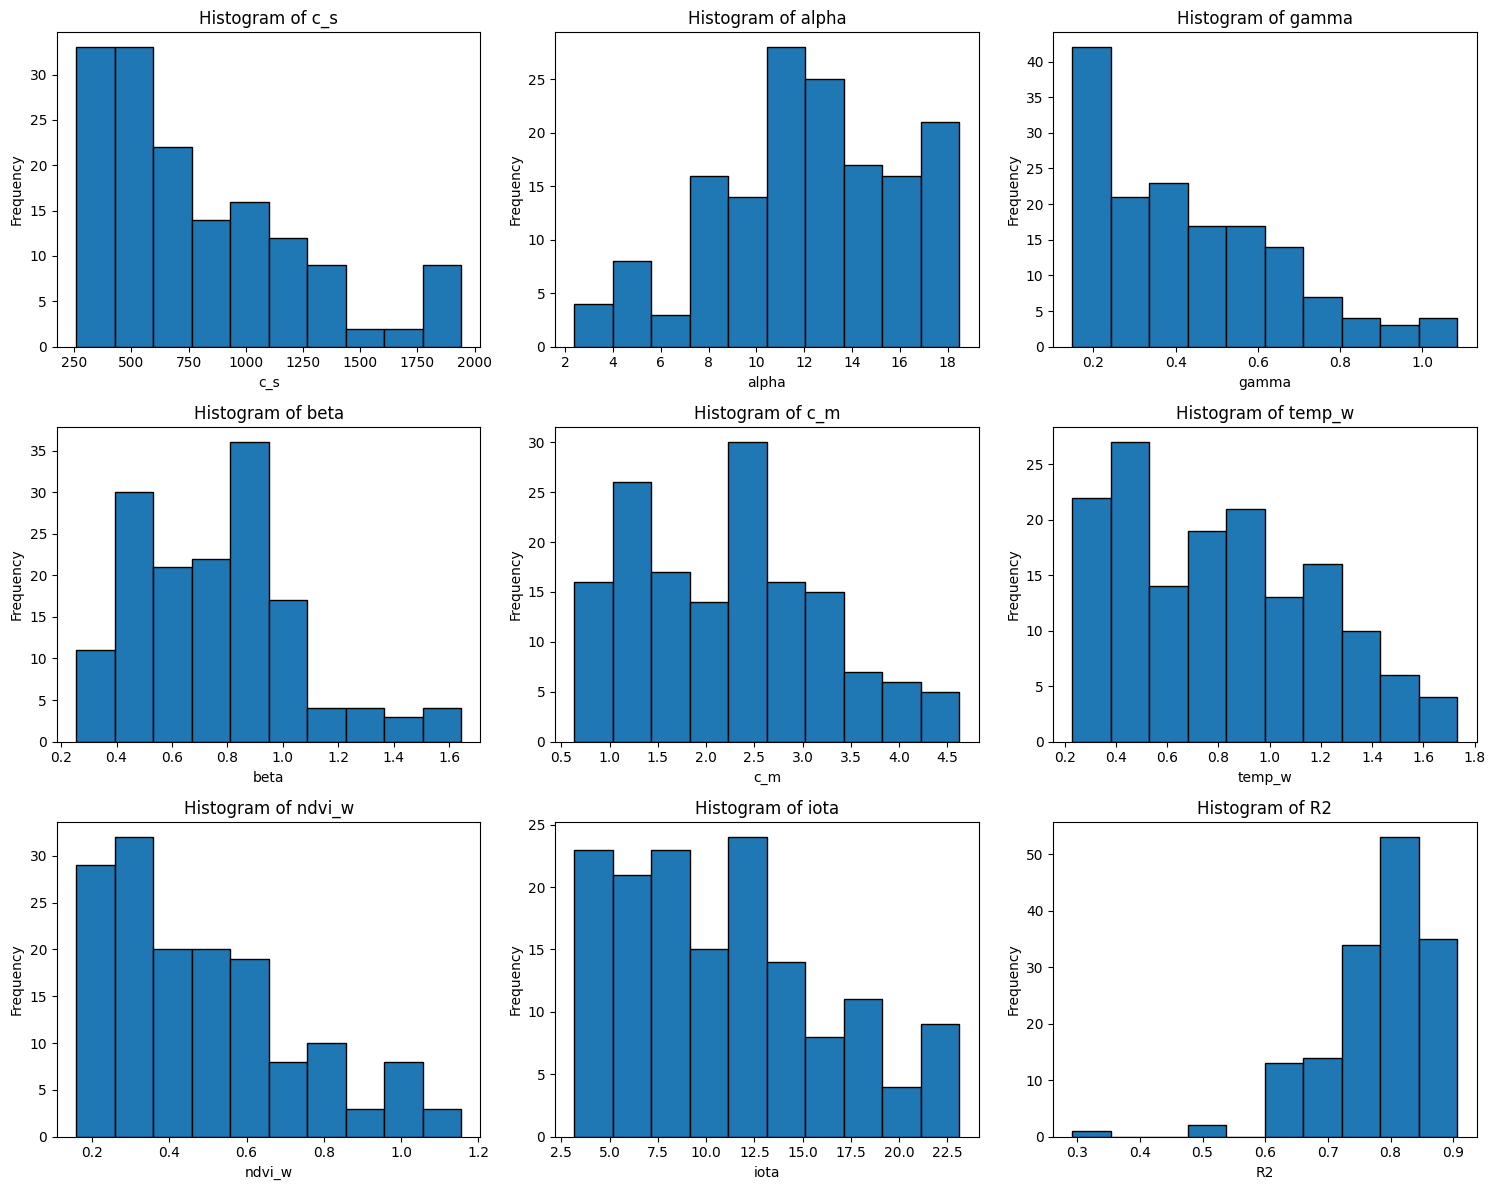

In [9]:
all_keys = list(next(iter(allParams.values())).keys())
params = [k for k in all_keys]

# Create a dict of parameter values across catchments
param_values = {param: [res[param] for res in allParams.values()] for param in params}

# Plot
n_cols = 3
n_rows = int(np.ceil(len(params) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, param in enumerate(params):
    axes[i].hist(param_values[param], bins=10, edgecolor='black')
    axes[i].set_title(f"Histogram of {param}")
    axes[i].set_xlabel(param)
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

d:\OneDrive\Desktop\Landuse Modelling\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


<Axes: >

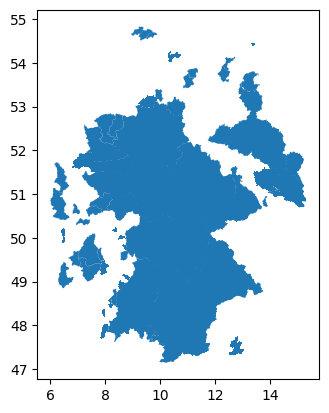

In [12]:
from shapely.geometry import box
import geopandas as gpd

catchments = gpd.read_file("data/catchments/stationbasins.geojson")
bbox = box(5.5, 47, 15.5, 55)
bbox_gdf = gpd.GeoDataFrame([[1]], geometry=[bbox], crs="EPSG:4326") 
filtered = catchments[catchments.geometry.within(bbox)]
filtered.plot()

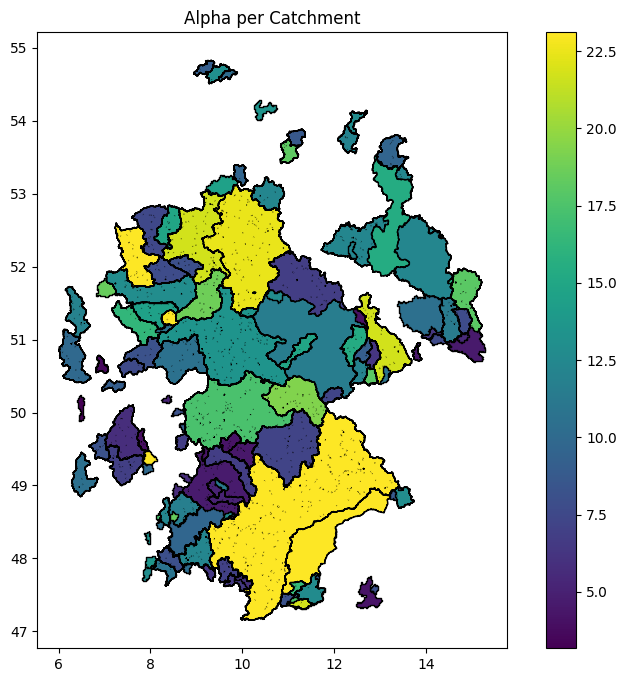

In [13]:
import pandas as pd

param_df = pd.DataFrame.from_dict(allParams, orient='index')
param_df.index.name = 'station'  # same name as in the GeoDataFrame

# Merge with the catchments GeoDataFrame
catchments_with_params = catchments.merge(param_df, on='station', how='left')

# Optional: filter by bounding box (you already have this)
bbox = box(5.5, 47, 15.5, 55)
bbox_gdf = gpd.GeoDataFrame([[1]], geometry=[bbox], crs="EPSG:4326") 
filtered = catchments_with_params[catchments_with_params.geometry.within(bbox)]

# Plot R2
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
filtered.plot(column='iota', ax=ax, legend=True, cmap='viridis', edgecolor='black')
ax.set_title('Alpha per Catchment')
plt.show()

In [14]:
filtered.to_file("outputs/all_catchment_parameters_without_theta.geojson", driver="GeoJSON")
filtered

,grdc_no,river,station,area,altitude,lat_org,long_org,lat_pp,long_pp,dist_km,...,geometry,c_s,alpha,gamma,beta,c_m,temp_w,ndvi_w,iota,R2
0,6321100.0,NIERS,GOCH,1203.0,12.02,51.6840,6.1510,51.68417,6.15083,0.0,...,"POLYGON ((6.2588 51.7171, 6.2588 51.7179, 6.25...",1609.222412,16.347656,0.585938,0.510864,0.771973,0.862083,0.593262,11.984253,0.890781
1,6321200.0,ROER,STAH,2105.0,32.45,51.0976,6.1042,51.09750,6.10417,0.0,...,"POLYGON ((6.0396 50.7721, 6.0388 50.7721, 6.03...",571.014404,14.381104,0.479370,0.450317,1.933594,1.628380,0.321655,9.933472,0.830632
2,6334270.0,SOHOLMER AU,SOHOLM,352.0,1.70,54.6997,9.0228,54.70000,9.02250,0.0,...,"POLYGON ((8.9671 54.6754, 8.9671 54.6754, 8.97...",756.533203,11.504883,0.679779,0.450317,1.589355,1.223602,0.613037,9.082031,0.867054
3,6334800.0,TREENE,TREIA,481.0,5.00,54.5143,9.3173,54.51417,9.31750,0.0,...,"POLYGON ((9.4962 54.5737, 9.4971 54.5737, 9.49...",364.757080,8.459473,0.317230,0.617578,2.610352,1.302704,0.726562,13.027039,0.871576
5,6335030.0,RUHR,HATTINGEN,4078.0,64.69,51.3997,7.1610,51.40000,7.16167,0.1,...,"POLYGON ((7.1887 51.3912, 7.1887 51.3921, 7.18...",456.811523,15.820312,0.476807,0.862866,3.867188,0.577812,0.773438,16.314697,0.876122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,6343555.0,RAMSAUER ACHE,ILSANK,122.3,576.16,47.6200,12.9500,47.61417,12.95000,0.6,...,"POLYGON ((12.9196 47.6279, 12.9196 47.6279, 12...",1941.448975,2.384033,0.510864,0.580078,0.675476,1.155624,0.337738,8.157349,0.634499
169,6343560.0,SAALACH,UNTERJETTENBERG,940.6,494.40,47.6812,12.8228,47.68120,12.82290,0.0,...,"POLYGON ((12.7875 47.7542, 12.8125 47.7542, 12...",1882.617188,3.480469,0.634460,1.543945,1.286621,0.681152,0.292969,4.229736,0.677389
171,6357501.0,LUSATIAN NEISSE RIVER,GUBEN 2,4080.0,37.48,51.9692,14.7069,51.96917,14.70750,0.0,...,"POLYGON ((14.7154 51.9513, 14.7146 51.9513, 14...",647.149658,15.325928,0.281448,0.408691,1.543945,1.628380,0.613037,17.976379,0.739689
172,6357502.0,LUSATIAN NEISSE RIVER,GOERLITZ,1621.0,175.63,51.1612,14.9932,51.16040,14.99380,0.1,...,"POLYGON ((14.9667 51.175, 14.975 51.175, 14.97...",976.171875,10.828125,0.257324,0.479370,1.687500,1.348228,0.539291,4.541016,0.733048


In [ ]:
station_ids = runoff["station_name"].values
match_index = [i for i, name in enumerate(station_ids) if name.lower() == folder_name.lower()]
        
        if not match_index:
            print(f"⚠️  No matching station found for folder: {folder_name}")
            continue

        station_index = match_index[0]

In [48]:
runoff["area"].sel({"station_name": "Bentfeld"})

KeyError: "'station_name' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'id': 174})"

In [53]:


areaBentfeld = runoff["area"].values[runoff["station_name"].values == "BENTFELD"].item()
areaBentfeld

1018.0

In [81]:
params_new = {
    "c_s": 840,
    "alpha": 8,
    "gamma": 0.5,
    "beta": 0.8,
    "c_m": 2.0,
    "temp_w": 0.75,
    "ndvi_w": 0.5,
    "iota": 10,
    "theta": 5
}

lowerBounds = [100, 1, 0, 0, 1, 0, 0, 1, 1]
upperBounds = [1500, 15, 1, 1, 5, 1, 1, 30, 15]

In [10]:
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame.from_dict(allData, orient='index')
df.index.name = "Catchment"

# Export to CSV
df.to_csv("catchment_parameters_without_theta.csv")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Union, Tuple


def initialize_population(
    pop_size: int,
    genome_length: int,
    lower_bounds: Union[float, List[float]],
    upper_bounds: Union[float, List[float]]
) -> np.ndarray:
    """
    Initialize a population uniformly within given bounds.
    """
    # Expand scalar bounds to lists
    if isinstance(lower_bounds, (int, float)):
        lower = np.full(genome_length, lower_bounds, dtype=float)
    else:
        lower = np.array(lower_bounds, dtype=float)
    if isinstance(upper_bounds, (int, float)):
        upper = np.full(genome_length, upper_bounds, dtype=float)
    else:
        upper = np.array(upper_bounds, dtype=float)

    return np.random.uniform(lower, upper, size=(pop_size, genome_length))


def evaluate_fitness(
    population: np.ndarray,
    fitness_func: Callable[[np.ndarray], float]
) -> np.ndarray:
    """
    Evaluate fitness for each individual in the population.
    """
    lKeys = {
    "c_s": 840,
    "alpha": 8,
    "gamma": 0.5,
    "beta": 0.8,
    "c_m": 2.0,
    "temp_w": 0.75,
    "ndvi_w": 0.5,
    "iota": 10,
    "theta": 5
    }.keys()
    return np.array([fitness_func(dict(zip(lKeys, ind))) for ind in population])


def select_parents(
    population: np.ndarray,
    fitnesses: np.ndarray,
    num_parents: int
) -> np.ndarray:
    """
    Roulette wheel (fitness-proportionate) selection.
    """
    # Shift fitness if negative or zero
    min_fit = np.min(fitnesses)
    if min_fit <= 0:
        fitnesses = fitnesses - min_fit + 1e-6
    total = np.sum(fitnesses)
    probs = fitnesses / total
    # choose with replacement
    indices = np.random.choice(
        np.arange(len(population)), size=num_parents, replace=True, p=probs
    )
    return population[indices]


def crossover(
    parent1: np.ndarray,
    parent2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Single-point crossover for float genomes.
    """
    length = len(parent1)
    if length < 2:
        return parent1.copy(), parent2.copy()
    point = np.random.randint(1, length)
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    return child1, child2


def mutate(
    individual: np.ndarray,
    mutation_rate: float,
    lower_bounds: Union[float, List[float]],
    upper_bounds: Union[float, List[float]],
    mutation_scale: float = 0.1
) -> np.ndarray:
    """
    Gaussian mutation: add noise to genes with given probability.
    mutation_scale is fraction of range.
    """
    # Expand bounds
    genome_length = len(individual)
    if isinstance(lower_bounds, (int, float)):
        lower = np.full(genome_length, lower_bounds, dtype=float)
    else:
        lower = np.array(lower_bounds, dtype=float)
    if isinstance(upper_bounds, (int, float)):
        upper = np.full(genome_length, upper_bounds, dtype=float)
    else:
        upper = np.array(upper_bounds, dtype=float)

    child = individual.copy()
    for i in range(genome_length):
        if np.random.rand() < mutation_rate:
            range_i = upper[i] - lower[i]++
            noise = np.random.normal(scale=mutation_scale * range_i)
            child[i] += noise
    # Clip to bounds
    return np.clip(child, lower, upper)


def select_survivors(
    combined_pop: np.ndarray,
    combined_fit: np.ndarray,
    pop_size: int
) -> Tuple[np.ndarray, np.ndarray]:
    """
    (mu + lambda) survivor selection: keep best individuals.
    """
    idx = np.argsort(combined_fit)[-pop_size:]
    return combined_pop[idx], combined_fit[idx]


def run_ga(
    fitness_func: Callable[[np.ndarray], float],
    genome_length: int,
    lower_bounds: Union[float, List[float]],
    upper_bounds: Union[float, List[float]],
    pop_size: int = 50,
    num_generations: int = 100,
    num_parents: int = 30,
    crossover_rate: float = 0.8,
    mutation_rate: float = 0.1,
    mutation_scale: float = 0.1,
    seed: int = None
) -> Tuple[np.ndarray, List[float], List[float]]:
    """
    Run the genetic algorithm and return the best solution and fitness progression.
    Returns (best_individual, best_fitness_history, avg_fitness_history).
    """
    if seed is not None:
        np.random.seed(seed)

    # Init
    population = initialize_population(pop_size, genome_length, lower_bounds, upper_bounds)
    fitnesses = evaluate_fitness(population, fitness_func)
    best_hist = []
    avg_hist = []

    # Evolution loop
    for gen in range(num_generations):
        # Record stats
        best_hist.append(np.max(fitnesses))
        avg_hist.append(np.mean(fitnesses))

        # Parent selection
        parents = select_parents(population, fitnesses, num_parents)

        # Generate offspring
        offspring = []
        while len(offspring) < pop_size:
            p1, p2 = parents[np.random.randint(len(parents))], parents[np.random.randint(len(parents))]
            if np.random.rand() < crossover_rate:
                c1, c2 = crossover(p1, p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            # Mutate
            c1 = mutate(c1, mutation_rate, lower_bounds, upper_bounds, mutation_scale)
            c2 = mutate(c2, mutation_rate, lower_bounds, upper_bounds, mutation_scale)
            offspring.extend([c1, c2])
        offspring = np.array(offspring[:pop_size])
        offspring_fit = evaluate_fitness(offspring, fitness_func)

        # Survivor selection
        combined_pop = np.vstack((population, offspring))
        combined_fit = np.concatenate((fitnesses, offspring_fit))
        #population, fitnesses = select_survivors(combined_pop, combined_fit, pop_size)
        population = select_parents(combined_pop, combined_fit, pop_size)
        fitnesses = evaluate_fitness(population, fitness_func)

    # Final stats
    best_hist.append(np.max(fitnesses))
    avg_hist.append(np.mean(fitnesses))
    best_idx = np.argmax(fitnesses)
    best_individual = population[best_idx]

    return best_individual, best_hist, avg_hist


# Example usage:
# if __name__ == '__main__':
#     # Define your fitness function:
#     def fitness(x):
#         return -np.sum(x**2)  # maximize negative sum of squares
#     best, best_hist, avg_hist = run_ga(
#         fitness_func=fitness,
#         genome_length=5,
#         lower_bounds=-5,
#         upper_bounds=5,
#         pop_size=100,
#         num_generations=50,
#         num_parents=40,
#         crossover_rate=0.9,
#         mutation_rate=0.05,
#         mutation_scale=0.2,
#         seed=42
#     )
#     print('Best individual:', best)
#     print('Best fitness:', best_hist[-1])


In [ ]:
def evaluate(params):
    wm = WaterModel(params=params, data=dataMean)
    runoff = wm.run_simulation_whole_catchment()
    mask = ~np.isnan(dataMean["observedRunoff"]) & ~np.isnan(runoff)

    if np.sum(mask) < 2:
        return params, -np.inf

    r, _ = pearsonr(runoff[mask], dataMean["observedRunoff"][mask])
    return r

In [ ]:
def evaluate_fast() -> np.float32:
    runoff,_,_,_ = time_evolution_numba(temp=temp,
                                        rad=rad,
                                        prec=prec,
                                        ndvi=ndvi,
                                        c_s=c_s,
                                        alpha=alpha,
                                        beta=beta,
                                        gamma=gamma,
                                        c_m=c_m,
                                        iota=iota,
                                        temp_w=temp_w,
                                        ndvi_w=ndvi_w)
    
    mask = ~np.isnan(observed) & ~np.isnan(runoff)
    if np.sum(mask) < 2:
        return params, -np.inf
    x = observed[mask]
    y= runoff[mask]
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    x_centered = x - x_mean
    y_centered = y - y_mean

    # Compute correlation
    numerator = np.sum(x_centered * y_centered)
    denominator = np.sqrt(np.sum(x_centered**2)) * np.sqrt(np.sum(y_centered**2))

    if denominator == 0:
        return 0.0

    return numerator / denominator

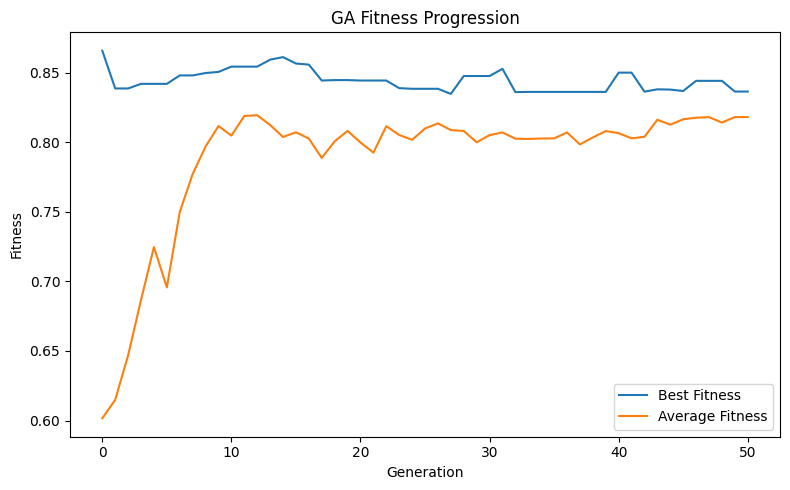

In [88]:
best, best_hist, avg_hist = run_ga(
    fitness_func=evaluate,
    genome_length=9,
    lower_bounds=lowerBounds,
    upper_bounds=upperBounds,
    pop_size=40,
    num_generations=50,
    num_parents=20,
    crossover_rate=0.7,
    mutation_rate=0.05,
    mutation_scale=0.2,
    seed=42,
)

In [89]:
best

array([618.37983547,  14.60041301,   0.75983889,   0.93762157,
         3.65474566,   0.69701574,   0.70780471,  12.05861878,
         5.21229634])

In [ ]:
'c_s': 486.3427734375, 'alpha': 12.375, 'gamma': 0.638580322265625, 'beta': 0.8234375, 'c_m': 0.794677734375, 'temp_w': 0.81573486328125, 'ndvi_w': 0.217529296875, 'iota': 3.955078125, 'theta': 2.255859375,